# Camera Intrinsic adjustments

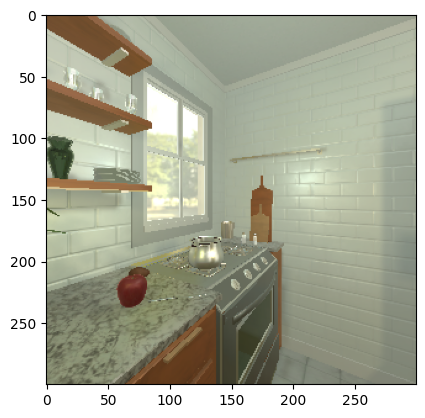

In [1]:
from ai2thor.controller import Controller
import matplotlib.pyplot as plt
import prior
import numpy as np
import cv2
import urllib
import os


controller = Controller(
    scene="FloorPlan4",
    renderDepthImage=True
)
event = controller.step("RotateLeft", degrees=30)
plt.imshow(event.frame)

In [2]:
event = controller.step("Pass")
# Apple
apple = event.metadata["objects"][0]


tomato = event.metadata["objects"][-3]

agent = event.metadata["agent"]

event.metadata["cameraPosition"], agent["cameraHorizon"], agent["rotation"]["y"], apple["position"], tomato["position"], apple, tomato

({'x': -2.0, 'y': 1.5759998559951782, 'z': 1.25},
 -0.0,
 240.0,
 {'x': -2.4803595542907715, 'y': 1.1838114261627197, 'z': 0.4803870916366577},
 {'x': -0.7468804717063904, 'y': 1.0815153121948242, 'z': 2.3995256423950195},
 {'name': 'Apple_381cdb86',
  'position': {'x': -2.4803595542907715,
   'y': 1.1838114261627197,
   'z': 0.4803870916366577},
  'rotation': {'x': 0.3139249384403229,
   'y': 0.0008034996571950614,
   'z': 0.29374414682388306},
  'visible': True,
  'isInteractable': True,
  'receptacle': False,
  'toggleable': False,
  'isToggled': False,
  'breakable': False,
  'isBroken': False,
  'canFillWithLiquid': False,
  'isFilledWithLiquid': False,
  'fillLiquid': None,
  'dirtyable': False,
  'isDirty': False,
  'canBeUsedUp': False,
  'isUsedUp': False,
  'cookable': False,
  'isCooked': False,
  'temperature': 'RoomTemp',
  'isHeatSource': False,
  'isColdSource': False,
  'sliceable': True,
  'isSliced': False,
  'openable': False,
  'isOpen': False,
  'openness': 0.0,
  

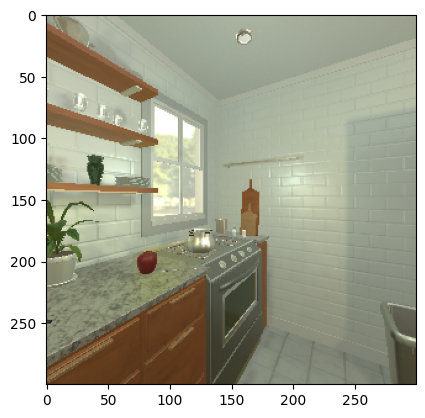

In [3]:
event = controller.step("MoveBack")
plt.imshow(event.frame)

In [4]:
controller.stop()

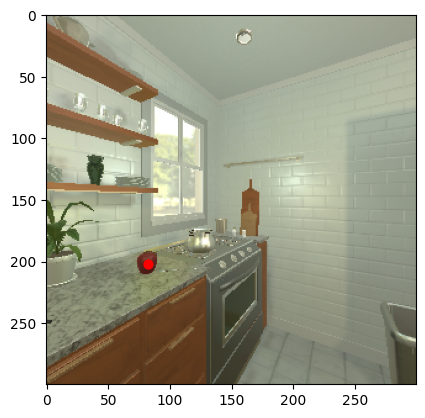

82.00251983940485 201.49909902107987


In [5]:
from scipy.spatial.transform import Rotation as R

def get_extrinsic_matrix(event):
    """
    Returns the 4x4 world-to-camera extrinsic matrix from event.metadata.
    
    Parameters
    ----------
    event : ai2thor Event
        The event object returned by controller.step()
    opencv_convention : bool
        If True, flip the camera Z-axis to match OpenCV's +Z-forward convention.
    """

    agent = event.metadata["agent"]
    cam_pos = event.metadata["cameraPosition"]

    # --- 1. Camera position in world coordinates
    tx, ty, tz = cam_pos["x"], cam_pos["y"], cam_pos["z"]

    # --- 2. Camera orientation (Unity convention)
    yaw = agent["rotation"]["y"]               # rotation about world Y (left/right)
    pitch = agent["cameraHorizon"]             # look up/down (+ means look down)
    roll = agent["rotation"]["z"]              # rarely nonzero

    # --- 3. Compose camera->world rotation (Unity order YXZ)
    R_c2w = R.from_euler('YXZ', [yaw, pitch, roll], degrees=True).as_matrix()

    # --- 4. Camera->world transform
    T_c2w = np.eye(4)
    T_c2w[:3, :3] = R_c2w
    T_c2w[:3, 3] = [tx, ty, tz]

    # --- 5. Invert to get world->camera
    T_w2c = np.linalg.inv(T_c2w)

    return T_w2c

def get_intrinsic_matrix():
    W, H, fov = 300, 300, 90
    fy = (H / 2) / np.tan(np.deg2rad(fov / 2))
    fx = fy
    cx, cy = W / 2, H / 2

    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]])
    
    return K

def world_to_pixel(world_point, event):
    K = get_intrinsic_matrix()
    T_w2c = get_extrinsic_matrix(event)

    # World → Camera
    Xw = np.array([world_point["x"], world_point["y"], world_point["z"], 1.0])
    Xc = (T_w2c @ Xw)[:3]  # camera coordinates (x_c, y_c, z_c)
    Xc[1] *= -1

    # Camera → Image (homogeneous)
    uv_h = K @ Xc
    u, v = uv_h[0] / uv_h[2], uv_h[1] / uv_h[2]
    return (u, v), Xc

(u, v), cam_coord = world_to_pixel(apple["position"], event)


plt.imshow(event.frame)
plt.scatter([u], [v], color='red', s=40)
plt.show()
print(u, v)

In [6]:

def pixel_to_world(u, v, depth, event):
    """
    Given a pixel (u, v) and its depth (in meters), return 3D world coordinates.
    """

    # --- 1. Camera intrinsics
    K = get_intrinsic_matrix()
    K_inv = np.linalg.inv(K)

    # --- 2. Camera extrinsics
    T_w2c = get_extrinsic_matrix(event)
    T_c2w = np.linalg.inv(T_w2c)

    # --- 3. Back-project pixel → camera coordinates
    pixel_h = np.array([u, v, 1.0])
    Xc = K_inv @ pixel_h * depth[int(v),int(u)]  # scale by depth
    Xc[1] *= -1                   # flip Y-axis (undo your projection correction)

    # --- 4. Convert camera → world coordinates (homogeneous)
    Xc_h = np.append(Xc, 1.0)
    Xw_h = T_c2w @ Xc_h
    Xw = Xw_h[:3]

    return dict(x=Xw[0], y=Xw[1], z=Xw[2])


pixel_to_world(u, v, event.depth_frame, event), apple["position"]

({'x': np.float64(-2.446391457090667),
  'y': np.float64(1.2020516129680276),
  'z': np.float64(0.5278079957301209)},
 {'x': -2.4803595542907715, 'y': 1.1838114261627197, 'z': 0.4803870916366577})

# Locate a single segmented object

In [7]:

dataset = prior.load_dataset("procthor-10k")
house = dataset["train"][3]
controller = Controller(scene=house, renderDepthImage=True, gridSize=0.125)

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 16121.96it/s]


TimeoutError: Error encountered when running action {'action': 'Initialize', 'renderDepthImage': True, 'gridSize': 0.125, 'sequenceId': 1} in scene Procedural.

In [ ]:

def get_weight(files_dict: dict[str, str]):
    target_dir = "data/face_detection"
    os.makedirs(target_dir, exist_ok=True)

    for fname, url in files_dict.items():
        out_path = os.path.join(target_dir, fname)
        if not os.path.exists(out_path):
            print(f"Downloading {fname}...")
            urllib.request.urlretrieve(url, out_path)
        else:
            print(f"{fname} already exists")


files_dict = {
    "dasiamrpn_model.onnx":
        "https://github.com/uozyurt/DaSiamRPN-OOP/raw/refs/heads/master/build/dasiamrpn_model.onnx",
    "dasiamrpn_kernel_r1.onnx":
        "https://github.com/uozyurt/DaSiamRPN-OOP/raw/refs/heads/master/build/dasiamrpn_kernel_r1.onnx",
    "dasiamrpn_kernel_cls1.onnx":
        "https://github.com/uozyurt/DaSiamRPN-OOP/raw/refs/heads/master/build/dasiamrpn_kernel_cls1.onnx",
}
get_weight(files_dict)

params = cv2.TrackerDaSiamRPN.Params()
params.model = "data/face_detection/dasiamrpn_model.onnx"
params.kernel_cls1 = "data/face_detection/dasiamrpn_kernel_cls1.onnx"
params.kernel_r1 = "data/face_detection/dasiamrpn_kernel_r1.onnx"
tracker = cv2.TrackerDaSiamRPN.create(params)

dasiamrpn_model.onnx already exists
dasiamrpn_kernel_r1.onnx already exists
dasiamrpn_kernel_cls1.onnx already exists


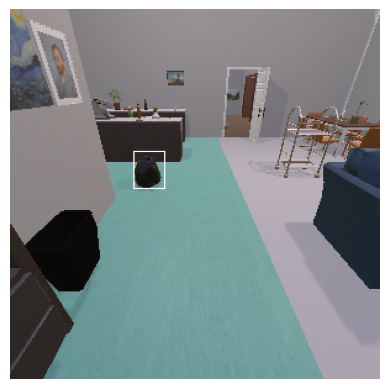

In [ ]:

event = controller.step("MoveAhead")


plt.imshow(event.depth_frame)
plt.axis(False)

fr = event.frame.copy()
bbox = (100, 115, 25, 30)

def cvt_bbox_to_edges(bbox):
    x, y, w, h = bbox
    return (int(x), int(y)), (int(x) + int(w), int(y) + int(h))

tracker.init(fr, bbox)

top_left, right_bot = cvt_bbox_to_edges(bbox)

cv2.rectangle(fr, top_left, right_bot, (255,255,255), 1)


plt.imshow(fr)

In [504]:
a = []

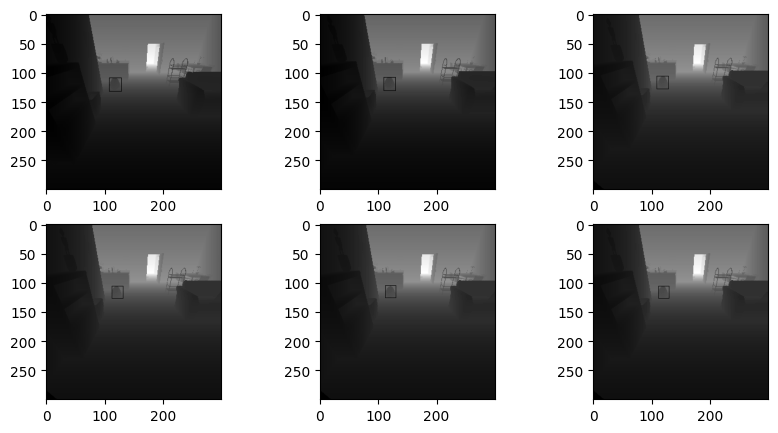

In [ ]:

epochs = 6
plt.figure(figsize=(10, 5))


for i in range(epochs):
    action = "MoveAhead" if np.random.randint(0, 2, (1,))[0] > 0 else "MoveBack"
    action = "MoveBack"

    for j in range(1):
        fr = event.frame.copy()
        event = controller.step(action)
        success, bbox = tracker.update(fr)
        # time.sleep(0.1)
        yaw_deg = event.metadata["agent"]["rotation"]["y"]

    top_left, right_bot = cvt_bbox_to_edges(bbox)

    x, y, w, h = bbox
    u, v = int(x + w // 2), int(y + h // 2)

    cam_pos = event.metadata["cameraPosition"]
    result = pixel_to_world(u, v, event.depth_frame, event)
    x, y, z = result["x"], result["y"], result["z"]

    dp_fr = event.depth_frame.copy()
    cv2.rectangle(dp_fr, top_left, right_bot, (1., 1., 1.), 1)
    a.append([cam_pos['x'], x.item()])


    plt.subplot(2, epochs / 2, i + 1)
    plt.imshow(dp_fr, cmap="gray")

plt.show()


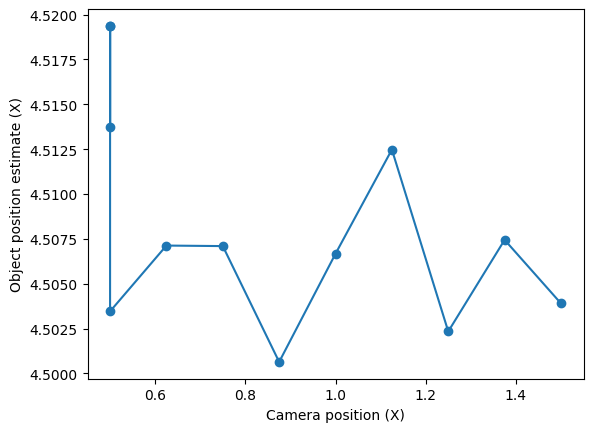

In [ ]:
positions = np.array(a)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(positions[:,0], positions[:,1], marker='o')
ax.set_xlabel("Camera position (X)")
ax.set_ylabel("Object position estimate (X)")
plt.show()


In [509]:
controller.stop()